# PART3 パラメータをチューニングしてみよう

## おまじない

In [96]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

## データの読み込み
- train.csvとtest.csvとsubmit_sample.csvの３つのファイルを読み込みましょう
- それぞれを読み込んだものは変数はtrain, test, sampleに代入しましょう

In [97]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)
sample = pd.read_csv('submit_sample.csv', header=None)

## trainから説明変数となるデータを取り出しましょう
- iloc[]を使います
- y以外を説明変数として取り出し、変数trainXに代入しましょう

In [98]:
trainX = train.iloc[:, :-1]
trainX

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
id,,,,,,,,,,,,,,,,
0,31,services,married,secondary,no,12294,yes,no,cellular,21,nov,101,3,498,0,other
1,29,entrepreneur,single,tertiary,no,43027,no,no,cellular,22,aug,158,2,702,0,unknown
2,35,management,married,tertiary,no,12252,yes,no,cellular,11,nov,351,1,826,0,failure
3,31,technician,married,secondary,no,99121,yes,yes,unknown,16,may,658,2,120,0,failure
4,48,unemployed,married,primary,no,42005,yes,no,telephone,3,apr,177,1,273,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27095,37,blue-collar,married,secondary,no,26661,yes,no,cellular,27,may,345,4,425,0,unknown
27096,35,services,married,secondary,no,42150,yes,no,cellular,27,may,121,1,719,0,unknown
27097,35,services,married,unknown,no,34531,no,no,cellular,28,jun,177,2,121,0,unknown


## trainから目的変数となるデータを取り出しましょう
- yを選択し、変数yに代入しましょう

In [99]:
y = train['y']

## testから説明変数となるデータを取り出しましょう
- testの全てのカラムが説明変数となりますので、copy関数を使って変数testXに代入します

In [100]:
testX = test.copy()

In [101]:
print(trainX.shape)
print(testX.shape)

(27100, 16)
(18050, 16)


In [102]:
trainX['train_test'] = 0
testX['train_test'] = 1
X = pd.concat([trainX, testX])
X.shape

(45150, 17)

In [103]:
train.corr()

,age,balance,day,duration,campaign,pdays,previous,y
age,1.000000,-0.001185,-0.059669,-0.055642,0.037633,0.008551,0.037545,0.086668
balance,-0.001185,1.000000,0.003816,0.003144,-0.001229,0.003018,0.009717,-0.000899
day,-0.059669,0.003816,1.000000,0.134440,-0.060326,-0.000433,-0.048624,-0.011804
duration,-0.055642,0.003144,0.134440,1.000000,-0.094643,0.003804,-0.015184,-0.030313
campaign,0.037633,-0.001229,-0.060326,-0.094643,1.000000,-0.003626,-0.038244,-0.030653
pdays,0.008551,0.003018,-0.000433,0.003804,-0.003626,1.000000,0.002187,-0.000116
previous,0.037545,0.009717,-0.048624,-0.015184,-0.038244,0.002187,1.000000,0.188473
y,0.086668,-0.000899,-0.011804,-0.030313,-0.030653,-0.000116,0.188473,1.000000


In [104]:
train['job'].value_counts()

blue-collar      5957
management       5346
technician       4915
admin.           3187
services         2471
self-employed    1163
entrepreneur     1155
retired          1004
unemployed        795
housemaid         754
student           353
Name: job, dtype: int64

In [105]:
test['job'].value_counts()

blue-collar      4086
management       3527
technician       3213
admin.           2152
services         1721
entrepreneur      729
self-employed     727
retired           657
unemployed        511
housemaid         496
student           230
unknown             1
Name: job, dtype: int64

## データ加工

### ビニング

In [106]:
age_bining = pd.cut(train['age'], [20,30,40,50,60,100])
age_bining

id
0        (30, 40]
1        (20, 30]
2        (30, 40]
3        (30, 40]
4        (40, 50]
           ...   
27095    (30, 40]
27096    (30, 40]
27097    (30, 40]
27098    (20, 30]
27099    (30, 40]
Name: age, Length: 27100, dtype: category
Categories (5, interval[int64]): [(20, 30] < (30, 40] < (40, 50] < (50, 60] < (60, 100]]

In [107]:
pd.crosstab(age_bining, train['y'], margins=True)

y,0,1,All
age,,,
"(20, 30]",4210,462,4672
"(30, 40]",16243,1014,17257
"(40, 50]",2765,297,3062
"(50, 60]",1757,339,2096
"(60, 100]",13,0,13
All,24988,2112,27100


In [108]:
duration_bining = pd.cut(train['duration'], [-1, 100,200,300,400,500,600,700,800,900,1000,5000])
duration_bining

id
0        (100, 200]
1        (100, 200]
2        (300, 400]
3        (600, 700]
4        (100, 200]
            ...    
27095    (300, 400]
27096    (100, 200]
27097    (100, 200]
27098    (100, 200]
27099    (300, 400]
Name: duration, Length: 27100, dtype: category
Categories (11, interval[int64]): [(-1, 100] < (100, 200] < (200, 300] < (300, 400] ... (700, 800] < (800, 900] < (900, 1000] < (1000, 5000]]

In [109]:
X['age_bining'] = pd.cut(X['age'], [20,30,40,50,60,100])
X['duration_bining'] = pd.cut(X['duration'], [-1, 100,200,300,400,500,600,700,800,900,1000,5000])


In [110]:
X

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,train_test,age_bining,duration_bining
id,,,,,,,,,,,,,,,,,,,
0,31,services,married,secondary,no,12294,yes,no,cellular,21,nov,101,3,498,0,other,0,"(30, 40]","(100, 200]"
1,29,entrepreneur,single,tertiary,no,43027,no,no,cellular,22,aug,158,2,702,0,unknown,0,"(20, 30]","(100, 200]"
2,35,management,married,tertiary,no,12252,yes,no,cellular,11,nov,351,1,826,0,failure,0,"(30, 40]","(300, 400]"
3,31,technician,married,secondary,no,99121,yes,yes,unknown,16,may,658,2,120,0,failure,0,"(30, 40]","(600, 700]"
4,48,unemployed,married,primary,no,42005,yes,no,telephone,3,apr,177,1,273,0,unknown,0,"(40, 50]","(100, 200]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18045,49,self-employed,married,tertiary,no,98357,yes,no,cellular,6,jul,101,2,417,0,failure,1,"(40, 50]","(100, 200]"
18046,34,blue-collar,married,secondary,no,29621,yes,no,cellular,12,may,345,1,815,0,unknown,1,"(30, 40]","(300, 400]"
18047,34,admin.,single,secondary,no,94260,yes,no,unknown,16,may,121,2,370,0,unknown,1,"(30, 40]","(100, 200]"


In [111]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45150 entries, 0 to 18049
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   age              45150 non-null  int64   
 1   job              45150 non-null  object  
 2   marital          45150 non-null  object  
 3   education        45150 non-null  object  
 4   default          45150 non-null  object  
 5   balance          45150 non-null  int64   
 6   housing          45150 non-null  object  
 7   loan             45150 non-null  object  
 8   contact          45150 non-null  object  
 9   day              45150 non-null  int64   
 10  month            45150 non-null  object  
 11  duration         45150 non-null  int64   
 12  campaign         45150 non-null  int64   
 13  pdays            45150 non-null  int64   
 14  previous         45150 non-null  int64   
 15  poutcome         45150 non-null  object  
 16  train_test       45150 non-null  int64  

## trainXとtestXをダミー変数化しましょう

In [112]:
cols_o = X.select_dtypes(include='object').columns.tolist()
cols_o

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [113]:
X = pd.get_dummies(X)
X

,age,balance,day,duration,campaign,pdays,previous,train_test,job_admin.,job_blue-collar,...,"duration_bining_(100, 200]","duration_bining_(200, 300]","duration_bining_(300, 400]","duration_bining_(400, 500]","duration_bining_(500, 600]","duration_bining_(600, 700]","duration_bining_(700, 800]","duration_bining_(800, 900]","duration_bining_(900, 1000]","duration_bining_(1000, 5000]"
id,,,,,,,,,,,,,,,,,,,,,
0,31,12294,21,101,3,498,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,29,43027,22,158,2,702,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,35,12252,11,351,1,826,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,31,99121,16,658,2,120,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,48,42005,3,177,1,273,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18045,49,98357,6,101,2,417,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
18046,34,29621,12,345,1,815,0,1,0,1,...,0,0,1,0,0,0,0,0,0,0
18047,34,94260,16,121,2,370,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0


In [114]:
# import category_encoders as ce
# ce_ohe = ce.OneHotEncoder(handle_unknown='impute')
# ce_ohe.fit(pd.concat([trainX, testX], axis=0))

# trainX = ce_ohe.transform(trainX)
# testX = ce_ohe.transform(testX)

### Objectだけにするとやはり精度が下がる
# ce_ohe.fit(pd.concat([trainX[cols_o], testX[cols_o]], axis=0))

# trainX = ce_ohe.transform(trainX[cols_o])
# testX = ce_ohe.transform(testX[cols_o])


In [115]:
# trainX

### 相関関係をチェック

In [116]:
corrs = []
_X = X[X['train_test'] == 0].drop(['train_test'], axis=1)
features = _X.columns

# print(features)

for c in features:
#     print(c, _X[c])
    corr = np.corrcoef(_X[c], y)[0, 1]
    corrs.append(corr)
corrs = np.array(corrs)


D:\anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [117]:
_X['job_unknown'].value_counts()

0    27100
Name: job_unknown, dtype: int64

In [118]:
idx = np.argsort(np.abs(corrs))[::-1]
#重要度上位10を格納
cols = _X.columns.values[idx][:10]
importances = corrs[idx][:10]

print(cols, importances)


['job_unknown' 'poutcome_success' 'previous' 'housing_no' 'housing_yes'
 'month_apr' 'month_mar' 'duration_bining_(300, 400]' 'month_oct'
 'month_may'] [        nan  0.29400639  0.18847302  0.16471042 -0.16471042  0.13239254
  0.12802761 -0.12578569  0.10934865 -0.10600027]


In [119]:
import seaborn as sns
sns.set()

xx = pd.concat([_X, y], axis=1).corr()['y'].abs().sort_values(ascending=False)[1:11]
xx

poutcome_success              0.294006
previous                      0.188473
housing_no                    0.164710
housing_yes                   0.164710
month_apr                     0.132393
month_mar                     0.128028
duration_bining_(300, 400]    0.125786
month_oct                     0.109349
month_may                     0.106000
marital_single                0.095064
Name: y, dtype: float64

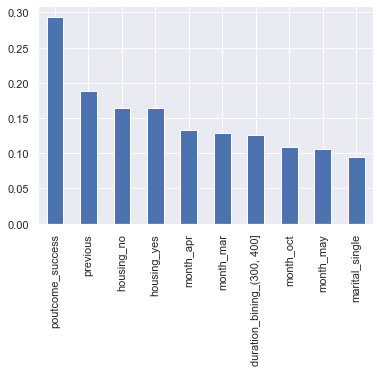

In [120]:
xx.plot.bar()

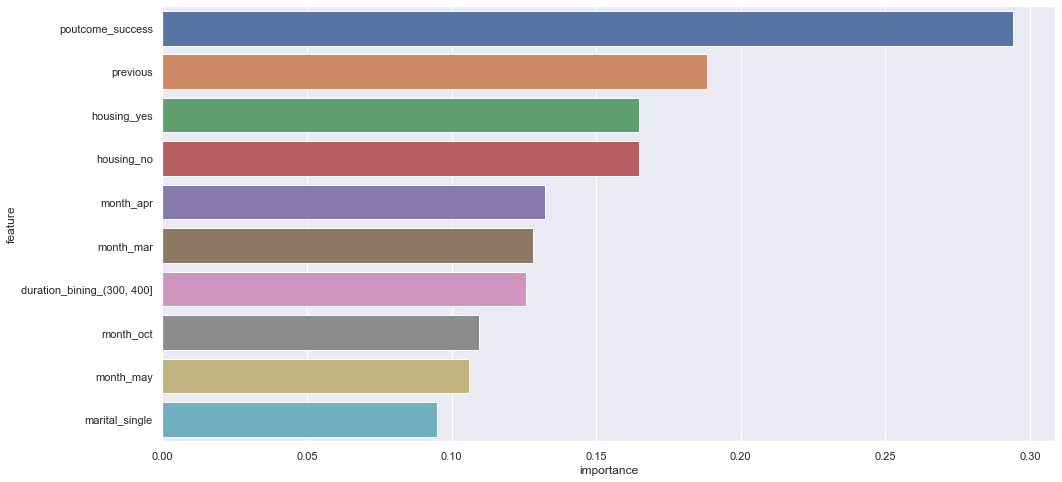

In [121]:
import seaborn as sns

feature_importances = pd.DataFrame()
feature_importances['feature'] = features
feature_importances['importance'] = abs(corrs)
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

plt.figure(figsize=(16, 8))
sns.barplot(data=feature_importances.head(10), x='importance', y='feature')

In [122]:
trainX = X[X['train_test'] == 0].drop(['train_test', 'age', 'duration'], axis=1)
testX = X[X['train_test'] == 1].drop(['train_test', 'age', 'duration'], axis=1)

In [123]:
trainX = X[X['train_test'] == 0].drop(['train_test', 'age', 'duration'], axis=1)
testX = X[X['train_test'] == 1].drop(['train_test', 'age', 'duration'], axis=1)

In [124]:
trainX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27100 entries, 0 to 27099
Data columns (total 64 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   balance                       27100 non-null  int64
 1   day                           27100 non-null  int64
 2   campaign                      27100 non-null  int64
 3   pdays                         27100 non-null  int64
 4   previous                      27100 non-null  int64
 5   job_admin.                    27100 non-null  uint8
 6   job_blue-collar               27100 non-null  uint8
 7   job_entrepreneur              27100 non-null  uint8
 8   job_housemaid                 27100 non-null  uint8
 9   job_management                27100 non-null  uint8
 10  job_retired                   27100 non-null  uint8
 11  job_self-employed             27100 non-null  uint8
 12  job_services                  27100 non-null  uint8
 13  job_student                   2

In [125]:
trainX.shape

(27100, 64)

In [126]:
testX.shape

(18050, 64)

In [127]:
trainX.columns

Index(['balance', 'day', 'campaign', 'pdays', 'previous', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar',
       'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown',
       'age_bining_(20, 30]', 'age_bining_(30, 40]', 'age_bining_(40, 50]',
       'age_bining_(50, 60]', 'age_bining_(60, 100]',
       'duration_bining

In [128]:
trainX.columns = ['balance', 'day', 'campaign', 'pdays', 'previous', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar',
       'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown',
       'age_bining_20', 'age_bining_30', 'age_bining_40',
       'age_bining_50', 'age_bining_60',
       'duration_bining_0', 'duration_bining_100',
       'duration_bining_200', 'duration_bining_300',
       'duration_bining_400', 'duration_bining_500',
       'duration_bining_600', 'duration_bining_700',
       'duration_bining_800', 'duration_bining_900',
       'duration_bining_1000']

## LightGBM

In [36]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score


In [37]:
parameters2 = {
    "max_depth": list(range(2,11)),
    'num_leaves': list(range(25, 50, 5)),
}

lgb = LGBMClassifier()

gcv3 = GridSearchCV(lgb, parameters2, cv=5, scoring="roc_auc", n_jobs=-1, return_train_score=True)
gcv3.fit(trainX, y)


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'nu

In [38]:
print(gcv3.best_params_)

pred3 = gcv3.predict_proba(testX)
pred3 = pred3[:,1]

roc_auc_score(y, gcv3.predict_proba(trainX)[:,1])
# 0.9113408811229391

# {'max_depth': 5, 'num_leaves': 32}
# 0.9118745842701466


{'max_depth': 4, 'num_leaves': 25}


0.8794484041733972

In [39]:
gcv3.cv_results_

{'mean_fit_time': array([0.36800013, 0.35119982, 0.34719872, 0.35359907, 0.39440041,
        0.42800035, 0.41695666, 0.39599867, 0.43120112, 0.40880046,
        0.4631999 , 0.47440047, 0.46080098, 0.49520049, 0.47519932,
        0.55359945, 0.54561386, 0.53864384, 0.53599901, 0.55679946,
        0.55600057, 0.61040025, 0.6031992 , 0.6415997 , 0.64334979,
        0.60909905, 0.65920086, 0.65279918, 0.6687995 , 0.68800006,
        0.58559928, 0.63360019, 0.64515529, 0.73039927, 0.70079942,
        0.59199934, 0.6095994 , 0.63999882, 0.68479929, 0.69472175,
        0.58504138, 0.59519973, 0.64319921, 0.66399879, 0.67519855]),
 'std_fit_time': array([0.01042993, 0.00299387, 0.00159979, 0.01611972, 0.04444126,
        0.02039481, 0.02111036, 0.00438212, 0.00926078, 0.01274948,
        0.02076965, 0.02001628, 0.00775624, 0.00854177, 0.01865898,
        0.02271172, 0.01618995, 0.01631893, 0.00669322, 0.02943786,
        0.01012038, 0.01903306, 0.01831306, 0.01969376, 0.02310115,
        0.029

In [40]:
train_score = gcv3.cv_results_['mean_train_score']
test_score = gcv3.cv_results_['mean_test_score']

In [41]:
train_score

array([0.84204945, 0.84204945, 0.84204945, 0.84204945, 0.84204945,
       0.86479037, 0.86479037, 0.86479037, 0.86479037, 0.86479037,
       0.8860224 , 0.8860224 , 0.8860224 , 0.8860224 , 0.8860224 ,
       0.91022828, 0.91196469, 0.91207618, 0.91207618, 0.91207618,
       0.92134694, 0.92819717, 0.93179521, 0.93517835, 0.93706871,
       0.92769155, 0.93593341, 0.94395698, 0.94802961, 0.95223872,
       0.9310073 , 0.93959472, 0.9473847 , 0.9536844 , 0.95868112,
       0.93171699, 0.94131286, 0.95043193, 0.95726432, 0.96279108,
       0.93391932, 0.94513939, 0.95257649, 0.95899366, 0.96474985])

In [48]:
test_score

array([0.83077396, 0.83077396, 0.83077396, 0.83077396, 0.83077396,
       0.83944944, 0.83944944, 0.83944944, 0.83944944, 0.83944944,
       0.84153515, 0.84153515, 0.84153515, 0.84153515, 0.84153515,
       0.83902279, 0.83905306, 0.83982877, 0.83982877, 0.83982877,
       0.83663454, 0.83587846, 0.83625465, 0.83535176, 0.83562105,
       0.83595517, 0.83573584, 0.83395327, 0.83254329, 0.8318269 ,
       0.83695167, 0.83557454, 0.83267679, 0.83316326, 0.83133595,
       0.83720803, 0.83469964, 0.83268559, 0.83312681, 0.83004441,
       0.83673232, 0.83444578, 0.83177258, 0.82961157, 0.82997752])

([<matplotlib.axis.XTick at 0x2cc965b7e48>,
 <a list of 9 Text xticklabel objects>)

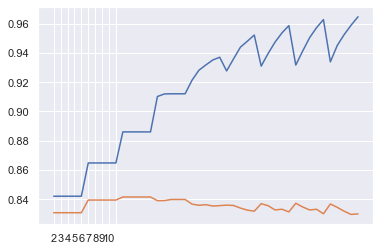

In [42]:
plt.plot(train_score)
plt.plot(test_score)
plt.xticks(list(range(0, 10)), list(range(2, 11)))

### 最適パラメータだけで調整用

In [46]:
lgb = LGBMClassifier(boosting_type='gbdt',  objective='binary', learning_rate=0.1, metric='auc', random_state=0, max_depth=5, num_leaves=32)


In [47]:
lgb.fit(trainX.values, y)
pred3 = lgb.predict_proba(testX.values)
pred3 = pred3[:,1]

roc_auc_score(y, lgb.predict_proba(trainX)[:,1])
# 0.9118745842701466


0.8794484041733972

## XGBoost

In [82]:
from xgboost import XGBClassifier

params = {'eta': [0.01, 0.1, 1.0],
          'gpu_id': [1],
         }

# params = {'max_depth': list(range(2, 10)),
#           'eta': [0.01, 0.1, 1.0],
#           'gamma': [0, 0.1],
#           'min_child_weight': [1, 2],
#           'nthread': [2, 4],
#           'n_estimators': list(range(50, 200, 50)),
#           'gpu_id': [1],
#          }

xgb = XGBClassifier()

reg_cv4 = GridSearchCV(xgb, params, cv=5, scoring="roc_auc", n_jobs=-1, return_train_score=True)
reg_cv4.fit(trainX.values, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
       

In [83]:
print(reg_cv4.best_params_)

pred4 = reg_cv4.predict_proba(testX.values)
pred4 = pred4[:,1]

roc_auc_score(y, reg_cv4.predict_proba(trainX.values)[:,1])


{'eta': 0.1, 'gpu_id': 1}


0.9176350765791823

In [84]:
train_score = reg_cv4.cv_results_['mean_train_score']
test_score = reg_cv4.cv_results_['mean_test_score']

([<matplotlib.axis.XTick at 0x2cc99906ac8>,
 <a list of 9 Text xticklabel objects>)

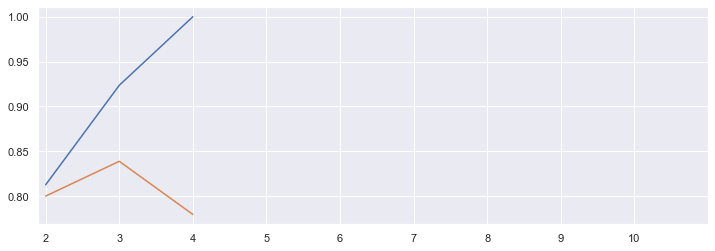

In [85]:
plt.figure(figsize=(12, 4))

plt.plot(train_score)
plt.plot(test_score)
plt.xticks(list(range(0, 10)), list(range(2, 11)))

In [ ]:
##### TODO 下のぱためーたをLoopで回す

In [139]:
params = {'max_depth': list(range(2, 10)),
          'eta': [0.01, 0.1, 1.0],
          'gamma': [0, 0.1],
          'min_child_weight': [1, 2],
          'nthread': [2, 4],
          'n_estimators': list(range(50, 200, 50)),
         }


In [140]:
for param in params:
    _tmp = {param: params[param]}
    _tmp['gpu_id'] = 1
    print(_tmp)


{'max_depth': [2, 3, 4, 5, 6, 7, 8, 9], 'gpu_id': 1}
{'eta': [0.01, 0.1, 1.0], 'gpu_id': 1}
{'gamma': [0, 0.1], 'gpu_id': 1}
{'min_child_weight': [1, 2], 'gpu_id': 1}
{'nthread': [2, 4], 'gpu_id': 1}
{'n_estimators': [50, 100, 150], 'gpu_id': 1}


{'max_depth': [2, 3, 4, 5, 6, 7, 8, 9], 'gpu_id': [1]}
{'gpu_id': 1, 'max_depth': 2}


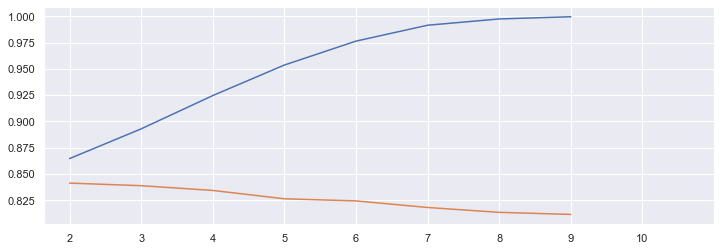

{'eta': [0.01, 0.1, 1.0], 'gpu_id': [1]}
{'eta': 0.1, 'gpu_id': 1}


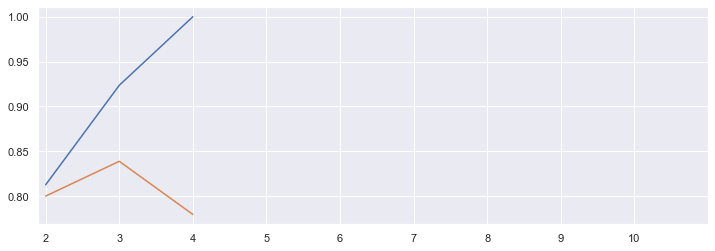

{'gamma': [0, 0.1], 'gpu_id': [1]}
{'gamma': 0, 'gpu_id': 1}


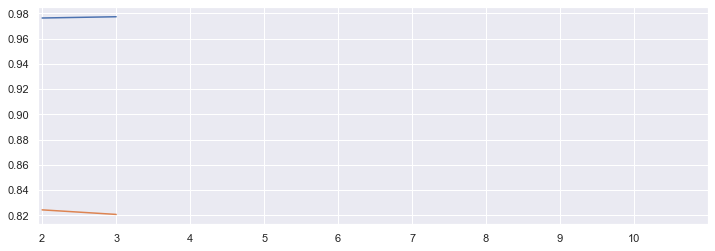

{'min_child_weight': [1, 2], 'gpu_id': [1]}
{'gpu_id': 1, 'min_child_weight': 1}


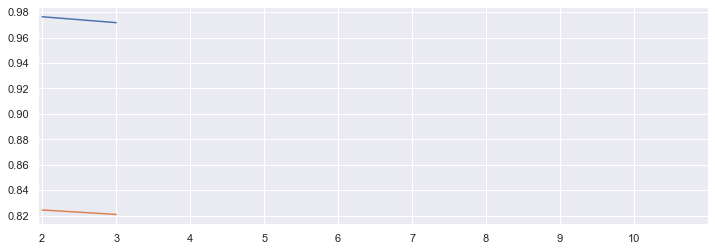

{'nthread': [2, 4], 'gpu_id': [1]}
{'gpu_id': 1, 'nthread': 2}


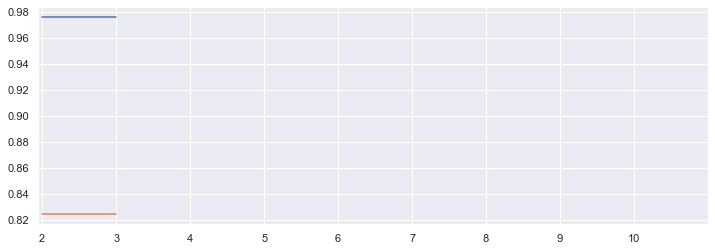

{'n_estimators': [50, 100, 150], 'gpu_id': [1]}
{'gpu_id': 1, 'n_estimators': 50}


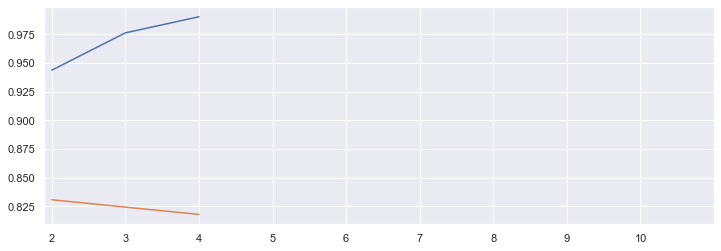

In [141]:
from xgboost import XGBClassifier

for param in params:
    _tmp = {param: params[param]}
    _tmp['gpu_id'] = [1]

    xgb = XGBClassifier()

    print(_tmp)
    reg_cv4 = GridSearchCV(xgb, _tmp, cv=5, scoring="roc_auc", n_jobs=-1, return_train_score=True)
    reg_cv4.fit(trainX.values, y)

    print(reg_cv4.best_params_)

    pred4 = reg_cv4.predict_proba(testX.values)
    pred4 = pred4[:,1]

    roc_auc_score(y, reg_cv4.predict_proba(trainX.values)[:,1])

    train_score = reg_cv4.cv_results_['mean_train_score']
    test_score = reg_cv4.cv_results_['mean_test_score']

    plt.figure(figsize=(12, 4))

    plt.plot(train_score)
    plt.plot(test_score)
    plt.xticks(list(range(0, 10)), list(range(2, 11)))
    plt.show()